# qnlp-tutorial

We go through the basics of DisCoPy and QNLP. On the menu:

1. [Drawing cooking recipes](#1.-Drawing-cooking-recipes)
2. [Tensors as boxes](#2.-Tensors-as-boxes)
3. [Drawing quantum circuits](#3.-Drawing-quantum-circuits)
4. [Drawing grammatical structure](#4.-Drawing-grammatical-structure)
5. [Putting it all together: QNLP](#5.-Putting-it-all-together:-QNLP)
6. [References](#References)

## 1. Drawing cooking recipes

An `Ob` (_object_) can be thought of as a basic ingredient in a recipe, it is defined only by its name, e.g. `'egg'`, `'sentence'`, `'qubit'`, etc.
A `Ty` (_type_) is simply a sequence of objects, i.e. a bunch of ingredients side by side, e.g. `Ty('egg', 'qubit')` represents an egg next to a qubit.
Types form a monoid with `@` (_tensor_) as product and `Ty()` (_the empty type_) as unit.
For example:

In [1]:
from discopy import Ob, Ty

egg, white, yolk = Ty('egg'), Ty('white'), Ty('yolk')

assert egg.objects == [Ob('egg')]
assert white @ yolk == Ty(Ob('white'), Ob('yolk'))

assert egg @ Ty() == egg == Ty() @ egg
assert egg @ (white @ yolk) == (egg @ white) @ yolk

Once we have defined some types, we can draw a `Box` with some types as `dom` (_domain_) and `cod` (_codomain_) which represent the inputs and outputs of a process. Note that we draw all our diagrams top to bottom.

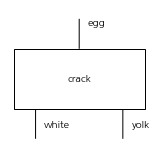

In [2]:
from discopy import Box

crack = Box('crack', dom=egg, cod=white @ yolk)

crack.draw(figsize=(2, 2))

We can put boxes side by side with `@` (_tensor_) and compose them in sequence with `>>` (_then_).

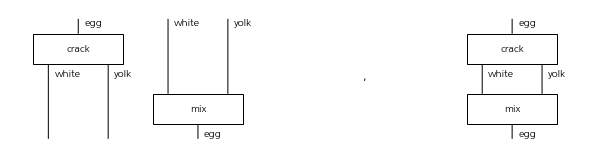

In [3]:
from discopy import drawing

mix = Box('mix', white @ yolk, egg)

crack_tensor_mix = crack @ mix
crack_then_mix = crack >> mix

drawing.equation(crack_tensor_mix, crack_then_mix, space=2, symbol=', ', figsize=(8, 2))

We can draw the `Id` (_identity_) for a type, i.e. just some parallel wires. Composing with an identity does nothing. Tensoring with `Id(Ty())` (_the empty diagram_) does nothing either.

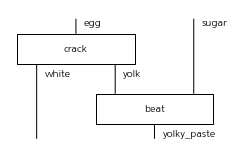

In [4]:
from discopy import Id

assert crack >> Id(white @ yolk) == crack == Id(egg) >> crack
assert crack @ Id(Ty()) == crack == Id(Ty()) @ crack

sugar, yolky_paste = Ty('sugar'), Ty('yolky_paste')
beat = Box('beat', yolk @ sugar, yolky_paste)

crack_then_beat = crack @ Id(sugar) >> Id(white) @ beat

crack_then_beat.draw(figsize=(3, 2))

We can change the order of ingredients using special boxes called `Swap`. This is needed for cooking indeed some recipes cannot be written on the plane. For example:

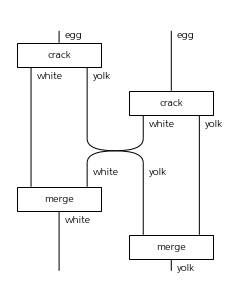

In [5]:
from discopy import Swap

merge = lambda y: Box('merge', y @ y, y)

crack_two_eggs = crack @ crack\
    >> Id(white) @ Swap(yolk, white) @ Id(yolk)\
    >> merge(white) @ merge(yolk)

crack_two_eggs.draw(figsize=(3, 4))

**Exercise:** Draw your favorite cooking recipe as a diagram. You'll want to keep your ingredients in order if you want to avoid swapping them too much.

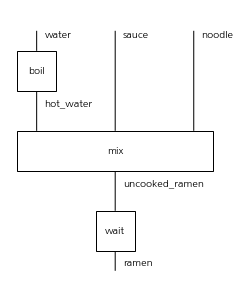

In [6]:
noodle, sauce, water = Ty('noodle'), Ty('sauce'), Ty('water')
hot_water, uncooked_ramen = Ty('hot_water'), Ty('uncooked_ramen')
ramen = Ty('ramen')

boil = Box('boil', water, hot_water)
mix_all = Box('mix', hot_water @ sauce @ noodle, uncooked_ramen)
wait = Box('wait', uncooked_ramen, ramen)

ramen_recipe = (boil @ Id(sauce @ noodle)) >> mix_all >> wait
ramen_recipe.draw(figsize=(3,4))

**Reading:** Check out Pawel's blogpost [Crema di mascarpone and diagrammatic reasoning](https://graphicallinearalgebra.net/2015/05/06/crema-di-mascarpone-rules-of-the-game-part-2-and-diagrammatic-reasoning/).

**Exercise:** Define a function that takes a number `n` and returns the recipe of a tiramisu with `n` layers of crema di mascarpone and savoiardi.

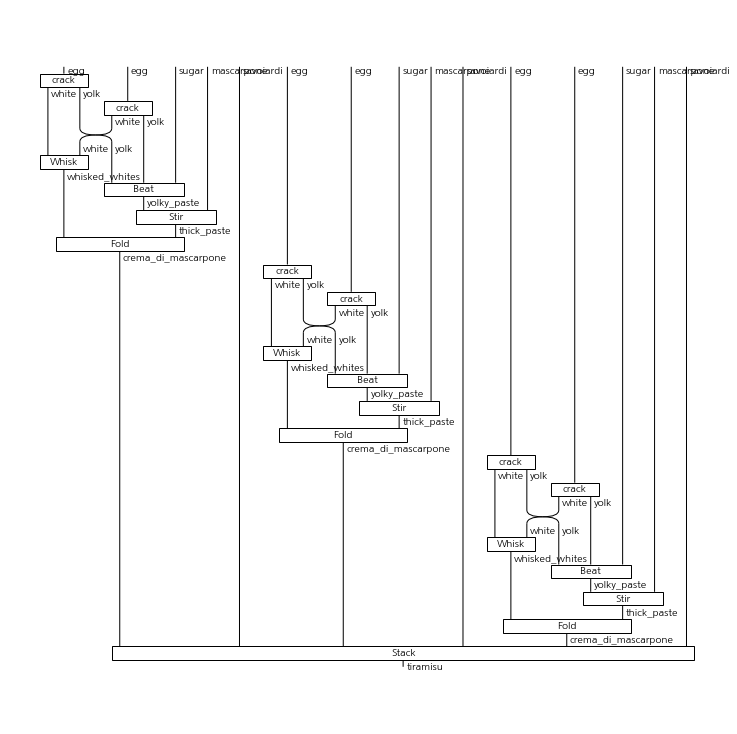

In [7]:
from typing import List, Tuple

mascarpone, whisked_whites, thick_paste, crema_di_mascarpone, savoiardi, tiramisu =\
    Ty('mascarpone'), Ty('whisked_whites'), Ty('thick_paste'), Ty('crema_di_mascarpone'), Ty('savoiardi'), Ty('tiramisu')
whisk = Box('Whisk', white @ white, whisked_whites)
beat2 = Box('Beat', yolk @ yolk @ sugar, yolky_paste)
stir = Box('Stir', yolky_paste @ mascarpone, thick_paste)
fold = Box('Fold', whisked_whites @ thick_paste, crema_di_mascarpone)

def duplicate_n(ob, _n):
    if _n < 1:
        raise ValueError
    codom = ob
    for i in range(_n-1):
        codom @= ob
    return Box('Duplicate', ob, codom)

def stack_n(_n):
    if _n < 1:
        raise ValueError
    layers = crema_di_mascarpone @ savoiardi
    for i in range(_n - 1):
        layers = layers @ crema_di_mascarpone @ savoiardi
    return Box('Stack', layers, tiramisu)

def swap_to_match(inp_priority: List[Tuple[Ty, int]]):
    _n = len(inp_priority)
    arr = list(inp_priority)
    ret = None
    for i in range(_n-1):
        for j in range(_n-i-1):
            if arr[j][1] > arr[j + 1][1] :
                tmp_ret = None
                for k in range(j):
                    inv_id = Id(arr[k][0])
                    tmp_ret = inv_id if tmp_ret is None else tmp_ret @ inv_id
                sw = Swap(arr[j][0], arr[j+1][0])
                tmp_ret = sw if tmp_ret is None else tmp_ret @ sw
                for k in range(j + 2, _n):
                    inv_id = Id(arr[k][0])
                    tmp_ret = inv_id if tmp_ret is None else tmp_ret @ inv_id
                ret = tmp_ret if ret is None else ret >> tmp_ret
                arr[j], arr[j + 1] = arr[j + 1], arr[j]
    return ret


def n_layer_of_crema_di_mascarpone(_n, verbose=False):
    if verbose:
        initial = duplicate_n(egg, 2 * _n) @ duplicate_n(sugar, _n) @ duplicate_n(mascarpone, _n) @ duplicate_n(savoiardi, _n)
        cur_priority = list()
        for i in range(_n):
            cur_priority.append((egg, 5*i))
            cur_priority.append((egg, 5*i+1))
        for i in range(_n):
            cur_priority.append((sugar, 5*i+2))
        for i in range(_n):
            cur_priority.append((mascarpone, 5*i+3))
        for i in range(_n):
            cur_priority.append((savoiardi, 5*i+4))
        initial >>= swap_to_match(cur_priority)
    else:
        initial = None
    inv_tiramisu = None
    for i in range(_n):
        add_layer = (
        (crack @ crack @ Id(sugar @ mascarpone))
        >> Id(white) @ Swap(yolk, white) @ Id(yolk @ sugar @ mascarpone)
        >> whisk @ beat2 @ Id(mascarpone)
        >> Id(whisked_whites) @ stir
        >> fold
        ) @ Id(savoiardi)
        inv_tiramisu = add_layer if inv_tiramisu is None else inv_tiramisu @ add_layer
    recipe = inv_tiramisu >> stack_n(_n) if initial is None else initial >> inv_tiramisu >> stack_n(_n)
    return recipe

n_layer_of_crema_di_mascarpone(3).draw(figsize=(10, 10))

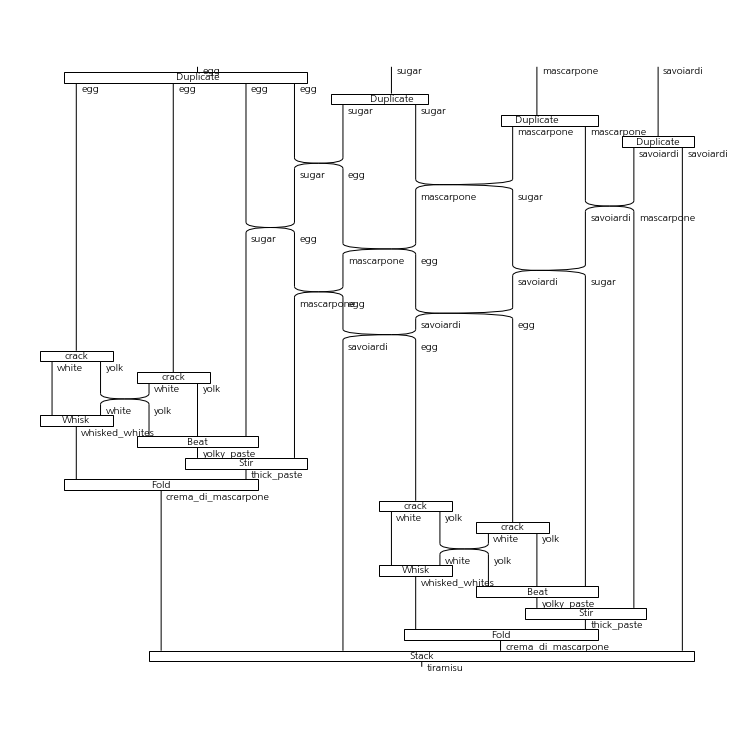

In [8]:
n_layer_of_crema_di_mascarpone(2, verbose=True).draw(figsize=(10, 10))

**Exercise (harder):** Define a function that takes a number `n` and returns the recipe for cracking `n` eggs.

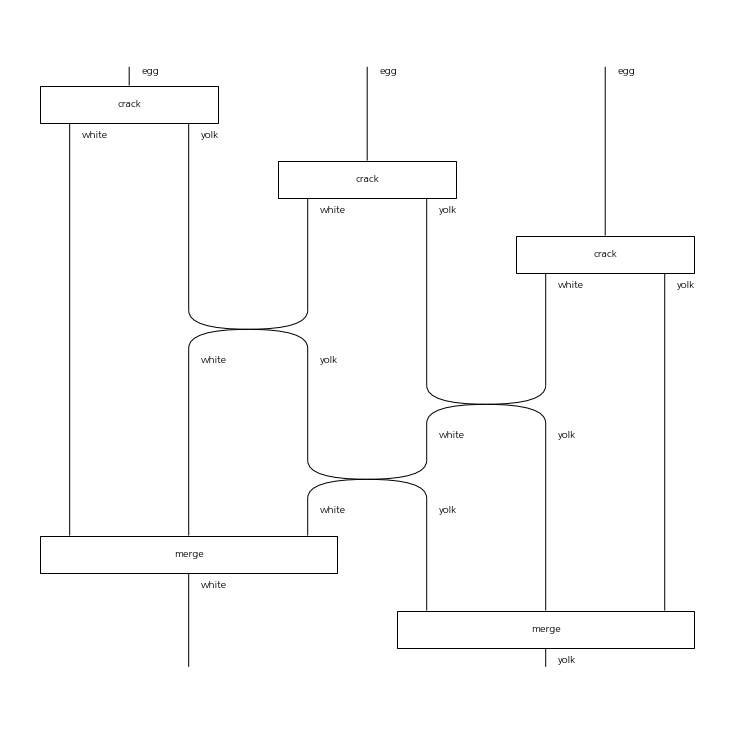

In [9]:
def merge_n(ob, _n):
    if _n < 2:
        raise ValueError
    dom = ob
    for i in range(_n-1):
        dom @= ob
    return Box('merge', dom, ob)

def crack_n_eggs(_n):
    if _n < 1:
        raise ValueError
    # crack
    ret = crack
    for i in range(_n - 1):
        ret = crack if ret is None else ret @ crack
    # swap
    for i in range(1, _n):
        idle_white = white
        idle_yolk = yolk
        for j in range(i - 1):
            idle_white @= white
            idle_yolk @= yolk
        num_swaps = _n - i
        sws = Swap(yolk, white)
        for k in range(num_swaps - 1):
            sws @= sws
        ret >>= Id(idle_white) @ sws @ Id(idle_yolk)
    # merge
    ret >>= merge_n(white, _n) @ merge_n(yolk, _n)
    return ret

crack_n_eggs(3).draw(figsize=(10, 10))

Anything we can draw using boxes, tensor, composition and identities is called a `Diagram`. A diagram is uniquely defined by a domain, a codomain, a list of boxes and a list of _offsets_. The offset of a box encodes its $x$-coordinate as the number of wires passing to its left, its $y$-coordinate is given by its index in the list. For example:

In [10]:
from discopy import Diagram

def pretty(diag):
    return "Diagram(\n"\
    + "    dom={},\n".format(repr(diag.dom))\
    + "    cod={},\n".format(repr(diag.cod))\
    + "    boxes=[{}],\n".format(',\n           '.join(map(repr, diag.boxes)))\
    + "    offsets={})".format(diag.offsets)

assertion = "assert crack_two_eggs == {}".format(pretty(crack_two_eggs))

exec(assertion)
print(assertion)

assert crack_two_eggs == Diagram(
    dom=Ty('egg', 'egg'),
    cod=Ty('white', 'yolk'),
    boxes=[Box('crack', Ty('egg'), Ty('white', 'yolk')),
           Box('crack', Ty('egg'), Ty('white', 'yolk')),
           Swap(Ty('yolk'), Ty('white')),
           Box('merge', Ty('white', 'white'), Ty('white')),
           Box('merge', Ty('yolk', 'yolk'), Ty('yolk'))],
    offsets=[0, 2, 1, 0, 1])


While `Diagram` is the core data structure of DisCoPy, `Functor` is its main algorithm. It is initialised by two mappings:

* `ob` maps objects (i.e. types of length `1`) to types,
* `ar` maps boxes to diagrams.

The functor takes a diagram, substitute each box by its image under the `ar` mapping and returns the resulting diagram. We can use this to "open a box", for example:

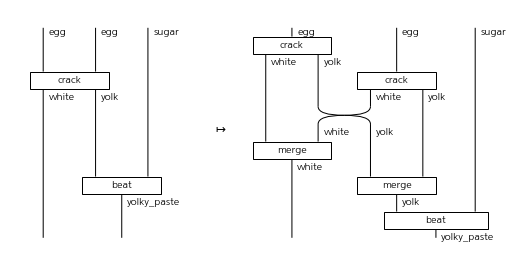

In [11]:
from discopy import Functor

crack2 = Box("crack", egg @ egg, white @ yolk)

open_crack2 = Functor(
    ob=lambda y: y,
    ar={crack2: crack_two_eggs, beat: beat})

crack2_then_beat = crack2 @ Id(sugar) >> Id(white) @ beat

drawing.equation(
    crack2_then_beat,
    open_crack2(crack2_then_beat),
    symbol='$\\mapsto$', figsize=(7, 3.5))

Another example of a functor is the translation from English cooking to French cuisine.

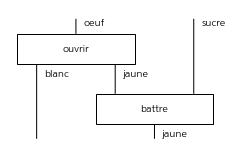

In [12]:
oeuf, blanc, jaune, sucre, jaune_pâte = Ty("oeuf"), Ty("blanc"), Ty("jaune"), Ty("sucre"), Ty("jaune_pâte")

ouvrir = Box("ouvrir", oeuf, blanc @ jaune)
battre = Box("battre", jaune @ sucre, jaune)

english2french = Functor(
    ob={egg: oeuf,
        white: blanc,
        yolk: jaune,
        sugar: sucre,
        yolky_paste: jaune_pâte},
    ar={crack: ouvrir,
        beat: battre})

english2french(crack_then_beat).draw(figsize=(3, 2))

Functors compose just like Python functions, e.g.

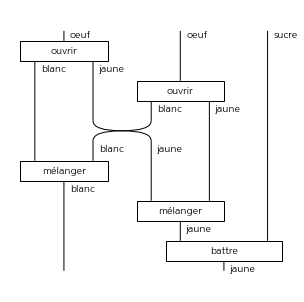

In [13]:
melanger = lambda y: Box("mélanger", y @ y, y)

for x in [white, yolk]:
    english2french.ar[merge(x)] = melanger(english2french(x))

english2french(open_crack2(crack2_then_beat)).draw(figsize=(4, 4))

**Exercise:** Define a functor that translate your favorite language to English, try composing it with `english2french`.

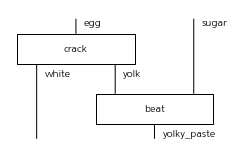

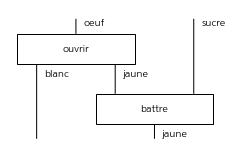

In [14]:
달걀, 흰자, 노른자, 설탕, 노른자_반죽 = Ty('달걀'), Ty('흰자'), Ty('노른자'), Ty('설탕'), Ty('노른자_반죽')
깨뜨리기 = Box("깨뜨리기", 달걀, 흰자 @ 노른자)
휘젓기 = Box("휘젓기", 노른자 @ 설탕, 노른자_반죽)

korean2english = Functor(
    ob={달걀: egg,
        흰자: white,
        노른자: yolk,
        설탕: sugar,
        노른자_반죽: yolky_paste},
    ar={깨뜨리기: crack,
        휘젓기: beat})

# from matplotlib import font_manager, rc
# font_path = "./NanumGothic.ttf"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

깨뜨리기_그리고_휘젓기 = 깨뜨리기 @ Id(설탕) >> Id(흰자) @ 휘젓기
# 깨뜨리기_그리고_휘젓기.draw(figsize=(3,2))
korean2english(깨뜨리기_그리고_휘젓기).draw(figsize=(3,2))
english2french(korean2english(깨뜨리기_그리고_휘젓기)).draw(figsize=(3,2))

**Exercise:** Define a `french2english` functor, check that it's the inverse of `english2french` on a small example.

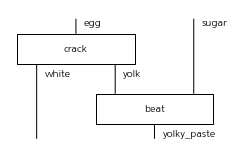

In [15]:
french2english = Functor(
    ob={oeuf: egg,
        blanc: white,
        jaune: yolk,
        sucre: sugar,
        jaune_pâte: yolky_paste},
    ar={ouvrir: crack,
        battre: beat})
french2english(english2french(crack_then_beat)).draw(figsize=(3,2))

## 2. Tensors as boxes

Sadly, Python is not very good at cooking, it doesn't even have a proper `coffee` module. There is one thing that Python's `numpy` module is good at though: computing with multi-dimensional arrays, a.k.a. **tensors**. We can interpret tensors as cooking steps with the dimensions of their axes as ingredients, i.e. **tensors are boxes**.

`Dim` (dimension) is a subclass of `Ty` where the objects are integers greater than 1, with multiplication as tensor and the unit dimension `Dim(1)`. `Tensor` is a subclass of `Box` defined by a pair of dimensions `dom, cod` and an `array` with shape `dom @ cod`.

In [16]:
from discopy import Dim, Tensor

matrix = Tensor(Dim(2), Dim(2), [0, 1, 1, 0])

matrix.array

array([[0, 1],
       [1, 0]])

Composition is given by matrix multiplication, with `Tensor.id` as identity, e.g.

In [17]:
assert matrix >> Tensor.id(Dim(2)) == matrix == Tensor.id(Dim(2)) >> matrix

vector = Tensor(Dim(1), Dim(2), [0, 1])

vector >> matrix

Tensor(dom=Dim(1), cod=Dim(2), array=[1, 0])

Tensor is given by the Kronecker product, with `Tensor.id(Dim(1))` as unit, e.g.

In [18]:
assert Tensor.id(Dim(1)) @ matrix == matrix == matrix @ Tensor.id(Dim(1))

Tensor.id(Dim(1))

Tensor(dom=Dim(1), cod=Dim(1), array=[1.])

In [19]:
vector @ vector

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0, 0, 0, 1])

In [20]:
vector @ matrix

Tensor(dom=Dim(2), cod=Dim(2, 2), array=[0, 0, 0, 1, 0, 0, 1, 0])

In practice, both composition and tensor are computed using `numpy.tensordot` and `numpy.moveaxis`.

In [21]:
import numpy as np

assert np.all(
    (matrix >> matrix).array == matrix.array.dot(matrix.array))
assert np.all(
    (matrix @ matrix).array == np.moveaxis(np.tensordot(
    matrix.array, matrix.array, 0), range(4), [0, 2, 1, 3]))

We can compute the conjugate transpose of a tensor using `[::-1]` (_dagger_).

In [22]:
matrix = Tensor(Dim(2), Dim(2), [0, -1j, 1j, 0])

matrix >> matrix[::-1]

Tensor(dom=Dim(2), cod=Dim(2), array=[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

Thus, we can compute the inner product of two vectors as a scalar tensor.

In [23]:
vector1 = Tensor(Dim(1), Dim(2), [-1j, 1j]) 

vector >> vector1[::-1]

Tensor(dom=Dim(1), cod=Dim(1), array=[0.-1.j])

We can add tensors elementwise, with the unit given by `Tensor.zeros`.

In [24]:
vector + vector

Tensor(dom=Dim(1), cod=Dim(2), array=[0, 2])

In [25]:
zero = Tensor.zeros(Dim(1), Dim(2))
assert vector + zero == vector == zero + vector

We can reorder the axes of the domain or codomain of a tensor by composing it with `Tensor.swap`.

In [26]:
swap = Tensor.swap(Dim(2), Dim(3))

assert swap.dom == Dim(2) @ Dim(3) and swap.cod == Dim(3) @ Dim(2)
assert swap >> swap[::-1] == Tensor.id(Dim(2, 3))
assert swap[::-1] >> swap == Tensor.id(Dim(3, 2))

matrix1 = Tensor(Dim(3), Dim(3), list(range(9)))

assert vector @ matrix1 >> swap == matrix1 @ vector
assert swap >> matrix1 @ matrix >> swap[::-1] == matrix @ matrix1

In order to turn a domain axis into a codomain axis or vice-versa, we can "bend the legs" of a tensor up and down using `Tensor.cups` and `Tensor.caps`.

In [27]:
cup, cap = Tensor.cups(Dim(2), Dim(2)), Tensor.caps(Dim(2), Dim(2))

print("cup == {}".format(cup))
print("cap == {}".format(cap))

cup == Tensor(dom=Dim(2, 2), cod=Dim(1), array=[1., 0., 0., 1.])
cap == Tensor(dom=Dim(1), cod=Dim(2, 2), array=[1., 0., 0., 1.])


In [28]:
_id = Tensor.id(Dim(2))

assert cap @ _id >> _id @ cup == _id == _id @ cap >> cup @ _id

The assertion just above is called the **snake equation**. It is pretty hard to see where this name comes from if we just try to draw the equation. Indeed, all three sides of the equation are just `Tensor` boxes with some array inside:

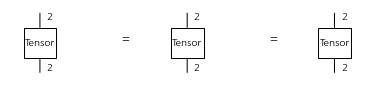

In [29]:
drawing.equation(cap @ _id >> _id @ cup, _id, _id @ cap >> cup @ _id, figsize=(5, 1))

In order to draw a more meaningful equation, we need to draw diagrams, not boxes. We can use the special `Cup` and `Cap` boxes to draw bended wires.

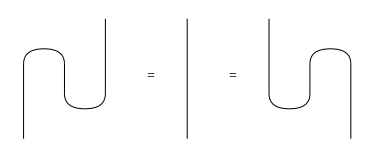

In [30]:
from discopy import Cup, Cap

left_snake = Cap(Dim(2), Dim(2)) @ Id(Dim(2)) >> Id(Dim(2)) @ Cup(Dim(2), Dim(2))
right_snake = Id(Dim(2)) @ Cap(Dim(2), Dim(2)) >> Cup(Dim(2), Dim(2)) @ Id(Dim(2))

drawing.equation(left_snake, Id(Dim(2)), right_snake, figsize=(5, 2), draw_type_labels=False)

Two diagrams that are drawn differently cannot be equal Python objects: they have different lists of boxes and offsets. What we can say however, is that the diagrams are interpreted as the same `Tensor` box. This interpretation can be computed using a `tensor.Functor`, defined by two mappings: `ob` from type to dimension (e.g. `qubit` to `Dim(2)`) and `ar` from box to array (e.g. `X` to `[0, 1, 1, 0]`). For now let's take these two mappings to be identity functions.

In [31]:
from discopy import tensor

_eval = tensor.Functor(
    ob=lambda y: y,
    ar=lambda y: y)

assert _eval(left_snake) == _eval(Id(Dim(2))) == _eval(right_snake)

A `tensor.Diagram`, also called a **tensor network**, is a subclass of `Diagram` equipped with such an `eval` method. A `tensor.Box`, also called a **node** in a tensor network, is a subclass of `Box` equipped with an attribute `array`. The evaluation a tensor diagram, i.e. the `tensor.Functor` that maps each box to its array, is also called **tensor contraction**.

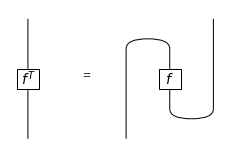

In [32]:
f = tensor.Box("$f$", Dim(2), Dim(2), [1, 2, 3, 4])
f_T = tensor.Box("$f^T$", Dim(2), Dim(2), [1, 3, 2, 4])

diagram = tensor.Diagram(
    dom=Dim(2), cod=Dim(2),
    boxes=[Cap(Dim(2), Dim(2)), f, Cup(Dim(2), Dim(2))],
    offsets=[0, 1, 1])

drawing.equation(f_T, diagram, figsize=(3, 2), fontsize=14, draw_type_labels=False)

assert not f_T == diagram
assert f_T.eval() == diagram.eval()

The distinction between a `tensor.Diagram` and its interpretation as a `Tensor` is crucial. Indeed, two diagrams that evaluate to the same tensor may take very different times to compute. For example: 

In [33]:
%timeit diagram.eval()

2.41 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
%timeit f_T.eval()

96.1 µs ± 630 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** Check out the [diagram rewriting](https://discopy.readthedocs.io/en/main/notebooks/rewriting-diagrams.html) notebook to learn how to remove snakes from a diagram. This can greatly speed up the evaluation of tensor diagrams!

We provide a simple example.

In [1]:
from discopy import Dim, Tensor
from discopy import Cup, Cap, tensor

In [2]:
Alice = tensor.Box('Alice', Dim(1), Dim(2), [1, 0])
Bob = tensor.Box('Bob', Dim(1), Dim(2), [1, 0])
loves = tensor.Box('loves', Dim(2, 2), Dim(1), Tensor.cups(Dim(2), Dim(2)))

def sentence_snake(n):
    top = Alice
    bottom = loves
    for i in range(n):
        top = top @ Cap(Dim(2), Dim(2)) @ Cap(Dim(2), Dim(2))
        bottom = Cup(Dim(2), Dim(2)) @ bottom @ Cup(Dim(2), Dim(2))
    top = top @ Bob
    sentence = top >> bottom
    return sentence

We can see how the snakes are removed from the diagram in the following.

In [5]:
lambda file: 'C:\\Users\\mathc\\PycharmProjects\\CohortProject_2021\\Week4_NLP\\image' + file
params = dict(
    aspect='auto',
    loop=True,
    draw_type_labels=False)

diagram = sentence_snake(3)
rewrite_steps = diagram.normalize()

diagram.to_gif(*rewrite_steps,
               path='simple_ex.gif', **params)

![reduce snakes](..\Week4NLP\image\simple_ex.gif)

We compare the evaluation time to see how inefficient it is when diagrams have many snakes.

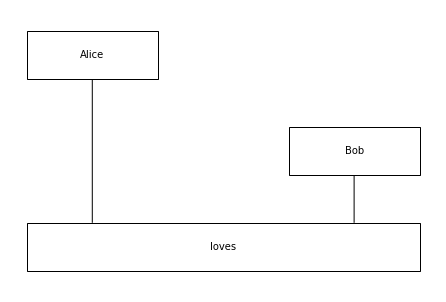

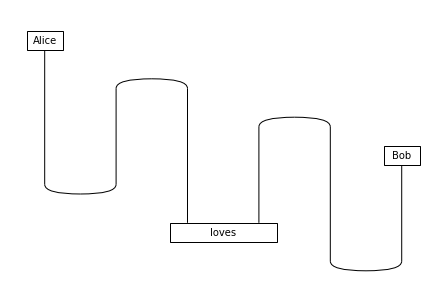

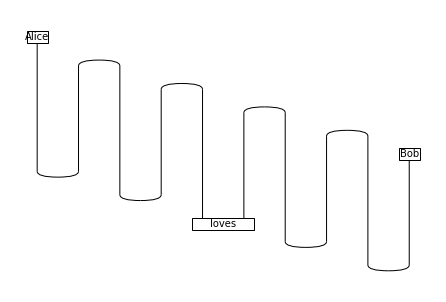

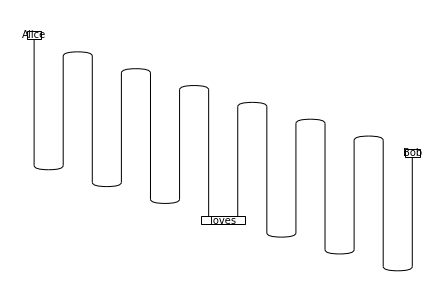

The slowest run took 4.22 times longer than the fastest. This could mean that an intermediate result is being cached.
4.99 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
20 ms ± 3.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.1 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
107 ms ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
102 ms ± 6.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
170 ms ± 5.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
806 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
sentence_snake(0).draw(draw_type_labels=False)
sentence_snake(1).draw(draw_type_labels=False)
sentence_snake(2).draw(draw_type_labels=False)
sentence_snake(3).draw(draw_type_labels=False)


%timeit -n 100 sentence_snake(0).eval()
%timeit -n 100 sentence_snake(1).eval()
%timeit -n 100 sentence_snake(2).eval()
%timeit -n 100 sentence_snake(3).eval()
%timeit -n 100 sentence_snake(4).eval()
%timeit -n 100 sentence_snake(5).eval()
%timeit -n 100 sentence_snake(6).eval()


**Exercise:** Define a function that takes a number `n` and returns the diagram for a [matrix product state](https://en.wikipedia.org/wiki/Matrix_product_state) (MPS) with `n` particles and random entries. Check how the evaluation time scales with the size of the diagram. 

MPS is of the form

$$ \left |\Psi \right \rangle = \sum_{s} \mathrm{Tr} \left[ A_{1}^{(s_{1})} A_{1}^{(s_{2})} \cdots A_{1}^{(s_{N})}\right] \left | s_{1}s_{2} \cdots s_{N} \right \rangle, $$

where $A_{i}^{(s_i)}$ are complex, square matrices.
As we can see, it is enough to compute $\mathrm{Tr} \left[ A_{1}^{(s_{1})} A_{1}^{(s_{2})} \cdots A_{1}^{(s_{N})}\right]$
to get the MPS state.
For simplicity, we here set $A_{i}^{(s_i)} = A_{j}^{(s_j)}$ for all $i$ and $j$.

We first consider the GHZ state as an example.

In [8]:
import numpy as np

M0 = [1, 0, 0, 0]
M1 = [0, 0, 0, 1]
A0 = tensor.Box('A0', Dim(2), Dim(2), M0)
A1 = tensor.Box('A1', Dim(2), Dim(2), M1)


In [9]:
def GHZ_MSP_coeff_step(n, i):
    binStr = format(i, 'b')
    binStr = binStr.zfill(n)
    if binStr[0] == '0':
        step = A0
    else:
        step = A1
    for j in range(1,n):
        if binStr[j] == '0':
            step = step >> A0
        else:
            step = step >> A1
    return step

In [10]:
def GHZ_MSP_coeff(n):
    diagram = GHZ_MSP_coeff_step(n,0)
    for j in range(1,2**n):
        diagram = diagram @ GHZ_MSP_coeff_step(n,j)
    return diagram


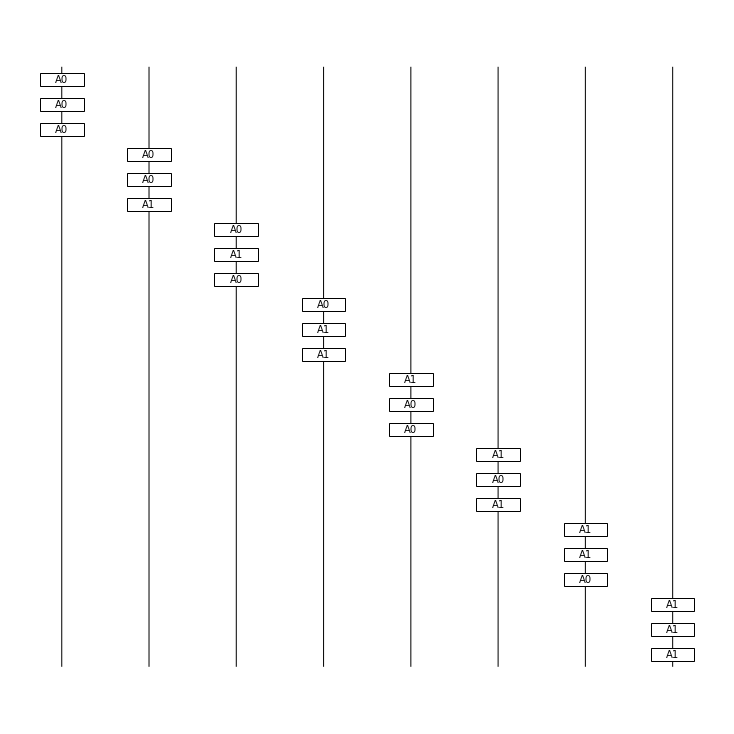

16.1 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
95 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


MemoryError: Unable to allocate 32.0 GiB for an array with shape (65536, 65536) and data type float64

In [11]:
GHZ_MSP_coeff(3).draw(figsize=(10, 10), draw_type_labels=False)
%timeit -n 10 GHZ_MSP_coeff(2).eval()
%timeit -n 10 GHZ_MSP_coeff(3).eval()
%timeit -n 10 GHZ_MSP_coeff(4).eval()

The following is the result of randomly selecting $A_{i}^{(s_i)}$.

In [12]:
RM = np.random.random_sample((2,4)) + 1j*np.random.random_sample((2,4))
RA0 = tensor.Box('RA0', Dim(2), Dim(2), RM[0])
RA1 = tensor.Box('RA1', Dim(2), Dim(2), RM[1])

def ran_MSP_coeff_step(n, i):
    binStr = format(i, 'b')
    binStr = binStr.zfill(n)
    if binStr[0] == '0':
        step = RA0
    else:
        step = RA1
    for j in range(1,n):
        if binStr[j] == '0':
            step = step >> RA0
        else:
            step = step >> RA1
    return step

def ran_MSP_coeff(n):
    diagram = ran_MSP_coeff_step(n,0)
    for j in range(1,2**n):
        diagram = diagram @ ran_MSP_coeff_step(n,j)
    return diagram

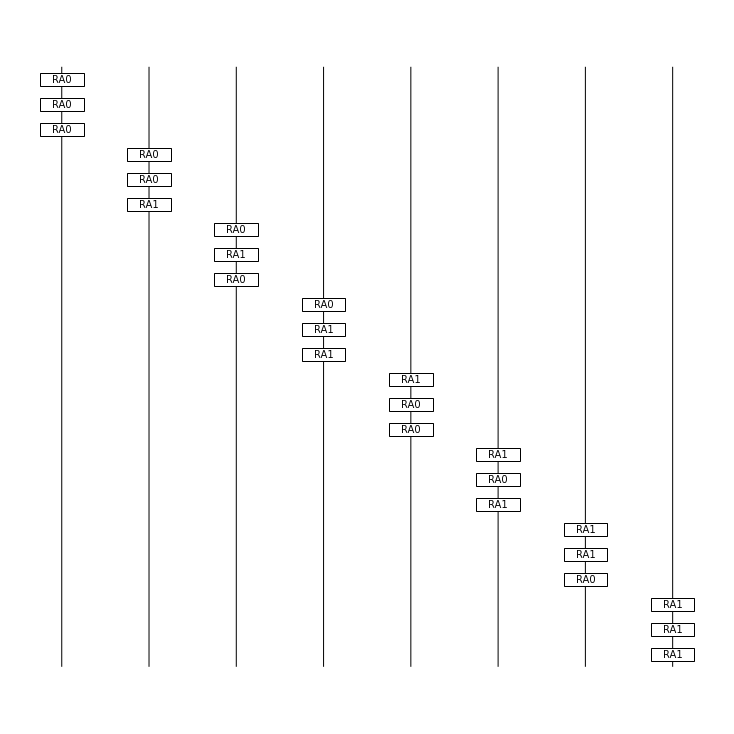

113 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
ran_MSP_coeff(3).draw(figsize=(10, 10), draw_type_labels=False)
%timeit -n 10 ran_MSP_coeff(3).eval()

**Exercise:** Pip install the [tensornetwork](https://pypi.org/project/tensornetwork/) library and use it to contract the MPS diagrams more efficiently. This is done with the syntax `diagram.eval(contractor=tn.contractor.auto)`, see the [docs](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html#discopy.tensor.Diagram.eval).

We did not solve this problem in the time given.
However, we can expect that the evaluation time can be effectively reduced by using the property $\mathrm{Tr}(AB)=\mathrm{Tr}(BA)$ in the above case.
For instance, if $N=3$,

$$\mathrm{Tr}(RA_{0}RA_{0}RA_{1})=\mathrm{Tr}(RA_{0}RA_{1}RA_{0})=\mathrm{Tr}(RA_{1}RA_{0}RA_{0})$$

and

$$\mathrm{Tr}(RA_{0}RA_{1}RA_{1})=\mathrm{Tr}(RA_{1}RA_{1}RA_{0})=\mathrm{Tr}(RA_{1}RA_{0}RA_{1}).$$

Hence, it is enough to calculate $\mathrm{Tr}(RA_{0}RA_{0}RA_{0})$, $\mathrm{Tr}(RA_{0}RA_{0}RA_{1})$,
$\mathrm{Tr}(RA_{0}RA_{1}RA_{1})$, and $\mathrm{Tr}(RA_{1}RA_{1}RA_{1})$ to get the MPS form in the above example.


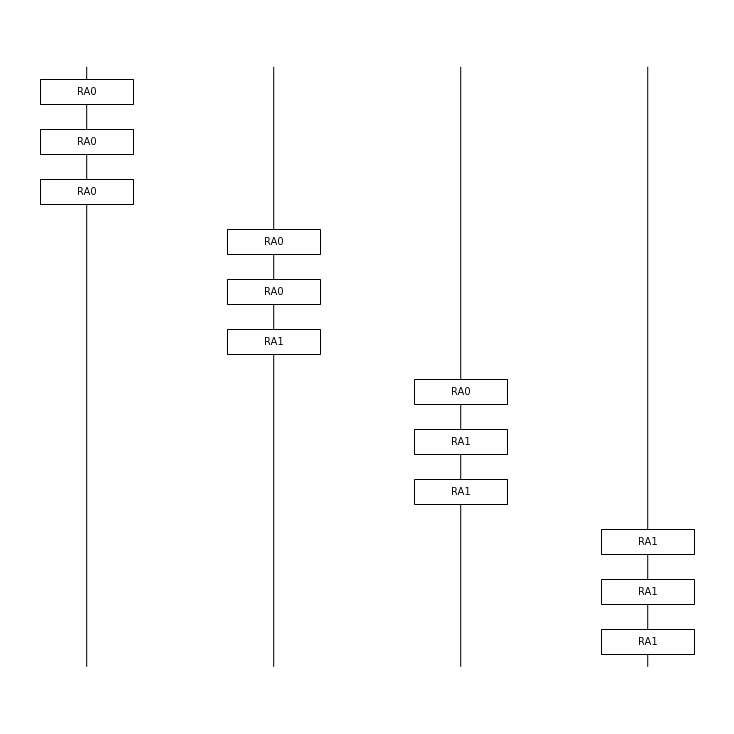

26.6 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
rew_ran_MSP_coeff = ran_MSP_coeff_step(3, 0) @ ran_MSP_coeff_step(3, 1) @ ran_MSP_coeff_step(3, 3) @ ran_MSP_coeff_step(3, 7)
rew_ran_MSP_coeff.draw(figsize=(10, 10), draw_type_labels=False)
%timeit -n 10 rew_ran_MSP_coeff.eval()

## 3. Drawing quantum circuits

A (_pure_) quantum `Circuit` is simply a recipe with qubits as ingredients and `QuantumGate` boxes as cooking steps. A quantum gate is defined by a number of qubits and a unitary matrix.

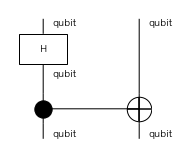

In [35]:
from discopy.quantum import qubit, H, Id, CX, QuantumGate

assert H == QuantumGate("H", 1, 1 / np.sqrt(2) * np.array([1, 1, 1, -1]), _dagger=None)

circuit = H @ Id(qubit) >> CX

circuit.draw(figsize=(2, 2), draw_type_labels=True, margins=(.1, .1))

A pure quantum circuit can be evaluated as a `Tensor` object, i.e. it is a subclass of `tensor.Diagram`.

In [36]:
assert H.eval() == H.array
assert Id(qubit).eval() == Tensor.id(Dim(2))

assert circuit.eval() == H.eval() @ Id(qubit).eval() >> CX.eval()

Pure quantum circuits are reversible. We call the reverse of a circuit its _dagger_, written with the operator `[::-1]`. 

CX >> H @ Id(1)


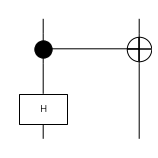

In [37]:
print(circuit[::-1])
circuit[::-1].draw(figsize=(2, 2), margins=(.1,.1))

In [38]:
assert (CX >> CX[::-1]).eval() == Id(qubit ** 2).eval()
assert np.all(np.isclose((H >> H[::-1]).eval(), Id(qubit).eval()))

Matrix multiplication is fun and all, but that's not really what quantum computers do. To simulate the quantum state that the circuit produces, we need to pre-compose it with a `Ket`, i.e. we need to initialise some qubits before we apply our circuit.
In our example `circuit`, the resulting state is the so called Bell state $\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$.

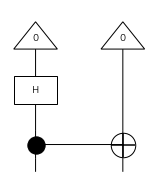

In [39]:
from discopy.quantum import Ket

(Ket(0, 0) >> circuit).draw(figsize=(2, 2.5))

In [40]:
(Ket(0, 0) >> circuit).eval()

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j])

To compute the probability of a particular measurement result, we need to post-compose our circuit with a `Bra`, the dagger of `Ket`, then apply the Born rule.

amplitude:


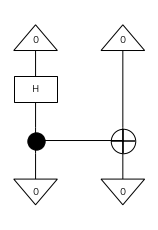

probability: 0.4999999999999999


In [41]:
from discopy.quantum import Bra

experiment = Ket(0, 0) >> circuit >> Bra(0, 0)

print("amplitude:")
experiment.draw(figsize=(2, 3))
amplitude = experiment.eval().array[0]

probability = abs(amplitude) ** 2
print("probability: {}".format(probability))

If we want to get the probability distribution over bitstrings, we need to leave the realm of purity to consider **mixed** quantum circuits with both `bit` and `qubit` ingredients.
The `Measure` box has `dom=qubit` and `cod=bit`.
Another example of a mixed box is `Discard` which computes a partial trace over a qubit.
Mixed circuits cannot be evaluated as a unitary matrix anymore.
Instead whenever the circuit is mixed, `circuit.eval()` outputs a `CQMap`: a `numpy.ndarray` with axes for the classical and quantum dimensions of the circuit.

In [42]:
from discopy.quantum import Measure, Discard

print(Discard().eval())
print(Measure().eval())

CQMap(dom=Q(Dim(2)), cod=CQ(), array=[1., 0., 0., 1.])
CQMap(dom=Q(Dim(2)), cod=C(Dim(2)), array=[1, 0, 0, 0, 0, 0, 0, 1])


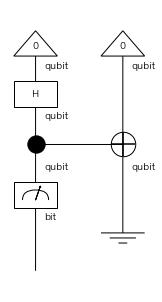

CQMap(dom=CQ(), cod=C(Dim(2)), array=[0.5+0.j, 0.5+0.j])

In [43]:
(Ket(0, 0) >> circuit >> Measure() @ Discard()).draw(figsize=(2, 4))
(Ket(0, 0) >> circuit >> Measure() @ Discard()).eval()

Note that as for diagrams of cooking recipes, we need to introduce swaps in order to apply two-qubit gates to non-adjacent qubits. These swaps have no physical meaning, they are just an artefact of drawing circuits in 2 dimensions rather than 4. Indeed, we can forget about swaps by compiling our planar diagram into the graph-based data structure of $\mathrm{t|ket\rangle}$.

In [44]:
from discopy.quantum import SWAP

circuit.to_tk()

tk.Circuit(2).H(0).CX(0, 1)

In [45]:
(SWAP >> circuit >> SWAP).to_tk()

tk.Circuit(2).H(1).CX(1, 0)

We can execute our circuit on a $\mathrm{t|ket\rangle}$ backend (simulator or hardware) by passing it as a parameter to `eval`.

In [46]:
from pytket.extensions.qiskit import AerBackend

aer = AerBackend()

(circuit >> Measure() @ Discard()).eval(backend=aer)

Tensor(dom=Dim(1), cod=Dim(2), array=[0.50097656, 0.49902344])

**Exercise:** Run your own Bell experiment on quantum hardware! You can use IBMQ machines for free, if you're ready to wait.

In [47]:
from qiskit import IBMQ

# IBMQ.load_account()
# provider = IBMQ.get_provider()
# backend = provider.get_backend('ibmq_lima')
# print((circuit >> Measure() @ Discard()).eval(backend=backend))

**Exercise:** Draw a circuit that evaluates to the GHZ state $\frac{1}{\sqrt{2}} (|000\rangle + |111\rangle)$.

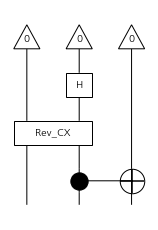

Tensor(dom=Dim(1), cod=Dim(2, 2, 2), array=[0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j,
 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j])


In [48]:
rev_cx_mat = np.array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
                       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
                       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
                       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])
Rev_CX = QuantumGate("Rev_CX", 2, rev_cx_mat, _dagger=None)
ghz_circuit = Ket(0, 0, 0)>>\
              Id(qubit) @ H @ Id(qubit) >>\
              Rev_CX @ Id(qubit) >>\
              Id(qubit) @ CX
ghz_circuit.draw(figsize=(2,3))
print(ghz_circuit.eval())

**Exercise (harder):** Define a function that takes a number `n` and returns a circuit for the  state $\frac{1}{\sqrt{2}} (|0...0\rangle + |1...1\rangle)$.

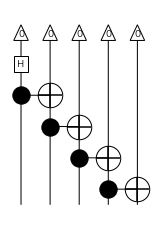

Tensor(dom=Dim(1), cod=Dim(2, 2, 2, 2, 2), array=[0.70710678+0.j, 0.    +0.j, 0.    +0.j, ..., 0.    +0.j,
 0.    +0.j, 0.70710678+0.j])


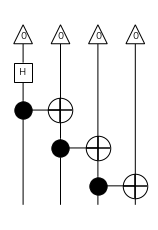

Tensor(dom=Dim(1), cod=Dim(2, 2, 2, 2), array=[0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j,
 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j,
 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j,
 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j])


In [49]:
def n_ghz_circuit(_n):
    def qubits(k):
        if k < 1:
            raise ValueError
        _ret = qubit
        for _ in range(k-1):
            _ret @= qubit
        return _ret
    ret = Ket(*(0,)*_n)
    if _n - 1 > 0:
        ret >>= H @ Id(qubits(_n-1))
    else:
        ret >>= H
    for i in range(_n-1):
        qubits_left = Id(qubits(i)) if i > 0 else None
        qubits_right = Id(qubits(_n - i - 2)) if _n - i - 2 > 0 else None
        if qubits_left is None and qubits_right is None:
            ret >>= CX
        elif qubits_left is None:
            ret >>= CX @ qubits_right
        elif qubits_right is None:
            ret >>= qubits_left @ CX
        else:
            ret >>= qubits_left @ CX @qubits_right
    return ret

ghz_5 = n_ghz_circuit(5)
ghz_5.draw(figsize=(2,3))
print(ghz_5.eval())

ghz_4 = n_ghz_circuit(4)
ghz_4.draw(figsize=(2,3))
print(ghz_4.eval())


## 4. Drawing grammatical structure

So far we've learnt how to draw diagrams of cooking recipes and how to evaluate quantum circuits. Now we're gonna see that diagrams can represent **grammatical structure**. The basic ingredients are grammatical types: `n` for noun, `s` for sentence, etc. Each ingredient has left and right adjoints `n.l` and `n.r` which represent a missing noun on the right and left respectively. For example, the type for intransitive verbs `n.r @ s` reads "take a noun on your left and give a sentence".

The cooking steps are of two kinds: words and cups. Words have no inputs, they output their own grammatical type. Cups have no outputs, they take as inputs two types `left` and `right` that cancel each other, i.e. such that `left.r == right`. The recipe for a sentence goes in three steps:

1. Tensor the word boxes together.
2. Compose with cups and identities.
3. Once there is only the sentence type `s` left, you parsed the sentence!

For example:

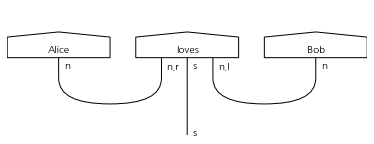

In [50]:
from discopy import Ty, Id, Word, Cup, pregroup

n, s = Ty('n'), Ty('s')

Alice = Word("Alice", n)
loves = Word("loves", n.r @ s @ n.l)
Bob = Word("Bob", n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentence = Alice @ loves @ Bob >> grammar
pregroup.draw(sentence, figsize=(5, 5))

Note that although in this tutorial we draw all our diagram by hand, this parsing process can be automated. Indeed once you fix a **dictionary**, i.e. a set of words with their possible grammatical types, it is completely mechanical to decide whether a sequence of words is grammatical. More precisely, it takes $O(n^3)$ time to decide whether a sequence of length $n$ is a sentence, and to output the diagram for its grammatical structure.

Such a dictionary is called a **pregroup grammar**, introduced by Lambek in 1999 and has been used to study the syntax of English, French, Persian and a dozen of other natural languages. Note that pregroup grammars are as expressive as the better known **context-free grammar**, where the diagrams are called **syntax trees**.

**Exercise:** Draw the diagram of a sentence in a language with a different word order, e.g. Japanese.

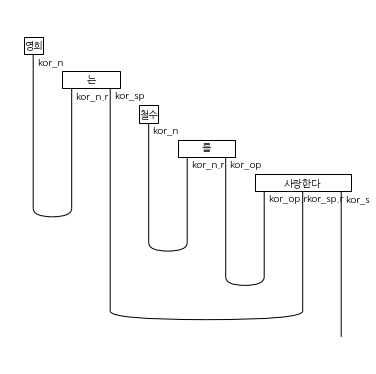

In [51]:
# Noun, Subjective/Objective Postpositions, Sentence
kor_n, kor_sp, kor_op, kor_s = Ty('kor_n'), Ty('kor_sp'), Ty('kor_op'), Ty('kor_s')

영희 = Word('영희', kor_n) # Korean version of 'Alice', Young-hee
는 = Word('는', kor_n.r @ kor_sp) # Subjective postposition
철수 = Word('철수', kor_n) # Korean version of 'Bob', Cheol-soo
를 = Word('를', kor_n.r @ kor_op) # Objective postposition
사랑한다 = Word('사랑한다', kor_op.r @ kor_sp.r @ kor_s) # Korean version of 'loves'

kor_grammar = Cup(kor_n, kor_n.r) @ Id(kor_sp) @ Cup(kor_n, kor_n.r) @ Cup(kor_op, kor_op.r) @ Id(kor_sp.r @ kor_s)\
        >> Cup(kor_sp, kor_sp.r) @ Id(kor_s)
        # >> Id(kor_sp) @ Swap(kor_op, kor_sp.r) @ Id(kor_op.r) @ Id(kor_s)\
        # >> Cup(kor_sp, kor_sp.r) @ Cup(kor_op, kor_op.r) @ Id(kor_s)

kor_sentence = 영희 @ 는 @ 철수 @ 를 @ 사랑한다

(kor_sentence>>kor_grammar).draw(figsize=(5, 5))

**Exercise:** Draw the diagram of a sentence in a language written right to left, e.g. Arabic.

/home/gwonhaklee/workspace/CohortProject_2021/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 1576 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gwonhaklee/workspace/CohortProject_2021/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 1608 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gwonhaklee/workspace/CohortProject_2021/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 1578 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gwonhaklee/workspace/CohortProject_2021/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 1581 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gwonhaklee/workspace/CohortProject_2021/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 1571 missing from c

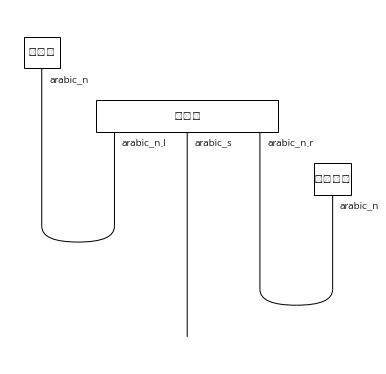

In [52]:
arabic_n, arabic_s = Ty('arabic_n'), Ty('arabic_s')
arabic_bob = Word('بوب', arabic_n)
arabic_loves = Word('تحب', arabic_n.l @ arabic_s @arabic_n.r)
arabic_alice = Word('أليس', arabic_n)

arabic_grammar = Cup(arabic_n, arabic_n.l) @ Id(arabic_s) @ Cup(arabic_n.r, arabic_n)
arabic_sentence = arabic_bob @ arabic_loves @ arabic_alice # Means, Alice loves bob.

(arabic_sentence>>arabic_grammar).draw(figsize=(5,5))

**Reading:** Check out Lambek's [From word to sentence](https://www.math.mcgill.ca/barr/lambek/pdffiles/2008lambek.pdf), pick your favorite example and implement it in DisCoPy.

Now the main idea behind DisCoCat (categorical compositional distributional) models is to interpret each word as a vector and the grammatical structure as a linear map.
Composing the tensor of word vectors with the linear map for grammar yields the meaning of the sentence.
Another way to say this is in the language of **tensor networks**:
computing the meaning of a sentence corresponds to tensor contraction along the grammatical structure.

Yet another way to say the same thing is in the language of **category theory**: computing the meaning of a sentence corresponds to the evaluation of a (strong monoidal) functor from a pregroup grammar to the category of linear maps.
Maybe that last sentence puts you off, since category theory is also known as "generalised abstract nonsense". Don't worry, you don't need to remember pages of axioms to use DisCoPy, it keeps track of them for you.

Let's build a simple toy model where:

* we map `n` to `2`, i.e. we encode a noun as a 2d vector,
* we map `s` to `1`, i.e. we encode a sentence as a scalar,
* we map `Alice` and `Bob` to `[0, 1]` and `[1, 0]`, i.e. we encode them as the basis vectors,
* we map `loves` to the matrix `[[0, 1], [1, 0]]`, i.e. `Alice loves Bob` and `Bob loves Alice`.

In [53]:
F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={Alice: [0, 1], loves: [0, 1, 1, 0], Bob: [1, 0]})

print(F(Alice @ loves @ Bob))
print(F(grammar))

assert F(Alice @ loves @ Bob >> grammar) == 1
assert F(Bob @ loves @ Alice >> grammar) == 1


Tensor(dom=Dim(1), cod=Dim(2, 2, 2, 2), array=[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
Tensor(dom=Dim(2, 2, 2, 2), cod=Dim(1), array=[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])


Since `F(sentence) == 1`, we conclude that the sentence is true, i.e. Alice loves Bob!

If we evaluate the meaning of noun phrases rather than sentences, we get vectors that we can compare using inner products. This gives us a similarity measure between noun phrases. In our toy model, we can say that Alice and Bob are different: we defined their meaning to be orthogonal.

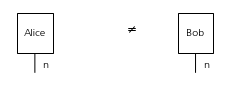

In [54]:
assert not F(Alice) >> F(Bob)[::-1] # Bob transposed
drawing.equation(Alice, Bob, symbol="$\\neq$", figsize=(3, 1))

Let's define some more words:

* we map `man` to `[1, 0]`, i.e. Bob is the only man in our model,
* we map the adjective `rich` of type `n @ n.l` to the projector `[[1, 0], [0, 0]]`, i.e. only Bob is rich.

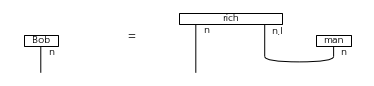

In [55]:
rich, man = Word("rich", n @ n.l), Word("man", n)

F.ar[rich], F.ar[man] = [1, 0, 0, 0], [1, 0]

rich_man = rich @ man >> Id(n) @ Cup(n.l, n)

assert F(Bob) >> F(rich_man)[::-1]  # i.e. Bob is a rich man.

drawing.equation(Bob, rich_man, figsize=(5, 1))

If we draw the diagram of a Who? question, the inner product with a noun phrase measures how well it answers the question.

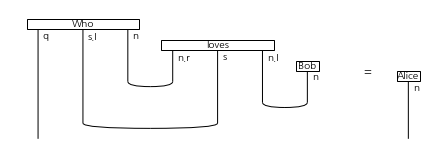

In [56]:
q = Ty('q')

Who = Word("Who", q @ s.l @ n)

F.ob[q], F.ar[Who] = 2, [1, 0, 0, 1]

question = Who @ loves @ Bob\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 

answer = Alice

assert F(question) == F(answer)

drawing.equation(question, answer, figsize=(6, 2))

**Exercise:** Draw your favorite sentence, define the meaning of each word then evaluate it as a tensor.

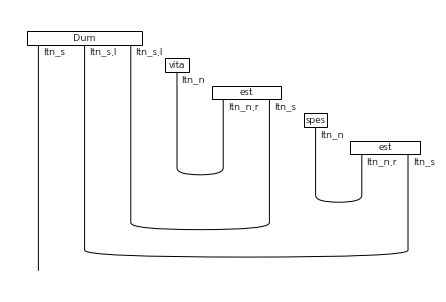

In [57]:
# Dum vita est, spes est. (Latin, While there is life, there is hope.)
# Dum = While, vita = life, est = there is, spes = hope
# latin_sc = Ty('ltn_sc') # subordinating conjunction
latin_n = Ty('ltn_n') # noun
latin_s = Ty('ltn_s') # sentence

Dum = Word("Dum", latin_s @ latin_s.l @ latin_s.l) # While
vita = Word("vita", latin_n) # life
est = Word("est", latin_n.r @ latin_s) # there is (or exists)
spes = Word("spes", latin_n) # hope

latin_sentence = Dum @ vita @ est @ spes @ est
latin_grammar = Id(latin_s @ latin_s.l @ latin_s.l) @ Cup(latin_n, latin_n.r) @ Id(latin_s) @ Cup(latin_n, latin_n.r) @ Id(latin_s)\
                >> Id(latin_s @ latin_s.l) @ Cup(latin_s.l, latin_s) @ Id(latin_s)\
                >> Id(latin_s) @ Cup(latin_s.l, latin_s)
(latin_sentence >> latin_grammar).draw()

**Exercise:** Build a toy model with a 4-dimensional noun space, add `Charlie` and `Diane` to the story.

In [58]:
from itertools import product

Charlie = Word("Charlie", n)
Diane = Word("Dian", n)
hates = Word("hates", n.r @ s @ n.l)
_and = Word("and", s.r @ s @ s.l)

love_vec = [1, 0, 1, 0,
            0, 1, 0, 1,
            0, 0, 1, 1,
            0, 0, 1, 1]
hate_vec = [0, 0, 0, 1,
            0, 0, 1, 0,
            0, 1, 0, 0,
            1, 0, 0, 0]
F_4d = tensor.Functor(
    ob={n: 4, s: 1},
    ar={Alice: [0, 0, 0, 1], Bob: [0, 0, 1, 0], Charlie: [0, 1, 0, 0], Diane: [1, 0, 0, 0],
        loves: love_vec, hates: hate_vec, _and: [1,]}
)
noun_list = [Alice, Bob, Charlie, Diane]
verb_list = [loves, hates]
and_grammar = Cup(s, s.r) @ Id(s) @ Cup(s.l, s)

print("Stories and facts :")
for sub, verb, obj in product(noun_list, verb_list, noun_list):
    print(f"{sub.name} {verb.name} {obj.name} : {True if F_4d(sub @ verb @ obj >> grammar) == 1 else False}")

print("\nConjuntions :")
for sub1, verb1, obj1, sub2, verb2, obj2 in product(noun_list, verb_list, noun_list, repeat=2):
    fact1, fact2 = F_4d(sub1 @ verb1 @ obj1 >> grammar), F_4d(sub2 @ verb2 @ obj2 >> grammar)
    con_facts = F_4d(sub1 @ verb1 @ obj1 @ _and @ sub2 @ verb2 @ obj2 >> grammar @ Id(s.r @ s @ s.l) @ grammar >> and_grammar)
    assert (fact1 and fact2) == con_facts
print("All confirmed")

Stories and facts :
Alice loves Alice : True
Alice loves Bob : True
Alice loves Charlie : False
Alice loves Dian : False
Alice hates Alice : False
Alice hates Bob : False
Alice hates Charlie : False
Alice hates Dian : True
Bob loves Alice : True
Bob loves Bob : True
Bob loves Charlie : False
Bob loves Dian : False
Bob hates Alice : False
Bob hates Bob : False
Bob hates Charlie : True
Bob hates Dian : False
Charlie loves Alice : True
Charlie loves Bob : False
Charlie loves Charlie : True
Charlie loves Dian : False
Charlie hates Alice : False
Charlie hates Bob : True
Charlie hates Charlie : False
Charlie hates Dian : False
Dian loves Alice : False
Dian loves Bob : True
Dian loves Charlie : False
Dian loves Dian : True
Dian hates Alice : True
Dian hates Bob : False
Dian hates Charlie : False
Dian hates Dian : False

Conjuntions :
All confirmed


**Exercise:** Define the meaning of the word `Does` and draw the diagram for the yes-no question `Does Alice love Bob?`. The meaning of the question should be the same as the sentence `Alice loves Bob`, i.e. the answer is "yes" if the sentence is true.

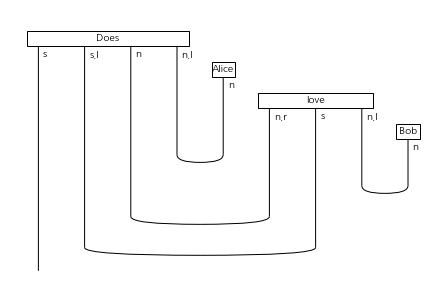

In [59]:
Does = Word("Does", s @ s.l @ n @ n.l)
love = Word("love", n.r @ s @ n.l)
does_grammar = Id(s) @ Id(s.l) @ Id(n) @ Cup(n.l, n) @ Id(n.r) @ Id(s) @ Cup(n.l, n)\
            >> Id(s) @ Id(s.l) @ Cup(n, n.r) @ Id(s)\
            >> Id(s) @ Cup(s.l, s)
does_sentence = Does @ Alice @ love @ Bob
(does_sentence >> does_grammar).draw()

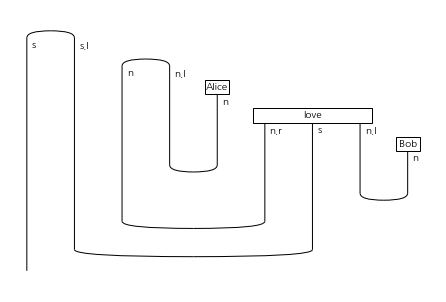

Does Alice love Bob ?
True


In [60]:
inside_does = Cap(s, s.l) @ Cap(n, n.l)
reduced_does_sentence = inside_does @ Alice @ love @ Bob >> does_grammar
reduced_does_sentence.draw()
F.ar[love] = F(loves).array

print(Does.name, Alice.name, love.name, Bob.name, "?")
print(bool(F(reduced_does_sentence).array))

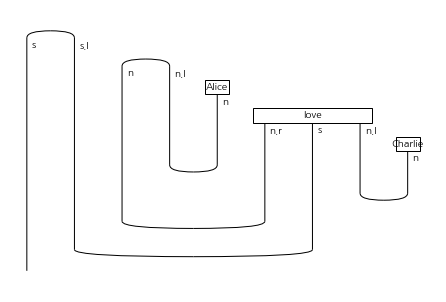

Does Alice love Charlie ?
False


In [61]:
F_4d.ar[love] = F_4d(loves).array
another_reduced_does_sentence = inside_does @ Alice @ love @ Charlie >> does_grammar
another_reduced_does_sentence.draw()

print(Does.name, Alice.name, love.name, Charlie.name, "?")
print(bool(F_4d(another_reduced_does_sentence)))

## 5. Putting it all together: QNLP

Let's recap what we've seen so far:

1. Diagrams can represent any cooking recipe, functors translate recipes.
2. Diagrams can represent any tensor network, tensor functors contract the network.
3. Diagrams can represent any quantum circuit, tensor functors simulate the circuit.
4. Diagrams can represent any grammatical sentence, tensor functors compute the meaning.

Now we've got all the ingredients ready for some quantum natural language processing! Indeed, the key insight behind QNLP is that instead of computing a functor $F : \mathbf{Grammar} \to \mathbf{Tensor}$ classically, we can split the computation into two steps $F = \mathbf{Grammar} \xrightarrow{F'} \mathbf{Circuit} \xrightarrow{\mathrm{eval}} \mathbf{Tensor}$: first we translate our grammatical structure into a quantum circuit, then we evaluate that quantum circuit to compute the meaning of the sentence.

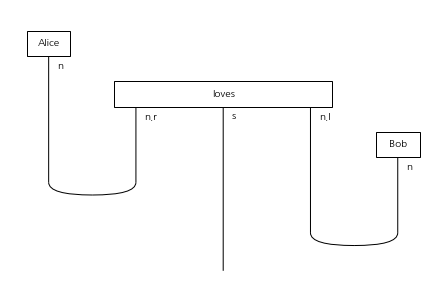

In [62]:
sentence.draw()

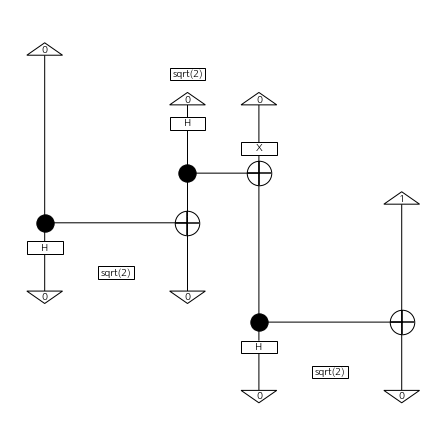

In [63]:
from discopy.quantum import circuit, qubit, sqrt, X

F_ = circuit.Functor(
    ob={s: Ty(), n: qubit},
    ar={Alice: Ket(0),
        loves: sqrt(2) @ Ket(0, 0) >> H @ X >> CX,
        Bob: Ket(1)})

F_(sentence).draw(figsize=(6, 6))

assert F_(sentence).eval() == F(sentence)

Of course this is a toy example: we've picked by hand what the circuits for Alice, loves and Bob should be so that they fit our interpretation. In order to apply our QNLP model to the real world, we need to **learn** from data what the circuits should be. In practice, we pick a parametrised circuit for each type of word, an **ansatz**, we then tune the parameters so that they reproduce our data.

**Reading:** Check out the [alice-loves-bob](https://discopy.readthedocs.io/en/main/notebooks/alice-loves-bob.html) notebook, where we use [jax](https://jax.readthedocs.io/) to simulate a toy QNLP model that learns the meaning of the verb "loves". In [bob-is-rich](https://discopy.readthedocs.io/en/main/notebooks/bob-is-rich.html), we show a slightly more complex example where the GHZ state is used to encode the meaning of relative pronouns.

**Reading:** Check out the [qnlp-experiment](https://discopy.readthedocs.io/en/main/notebooks/qnlp-experiment.html) where we run these toy models on quantum hardware.

**Exercise:** Run your own QNLP experiment on quantum hardware! There are multiple parameters that you can try to scale: the length of sentences, the size of the vocabulary, the number of qubits for the noun space.

**Exercise:** Implement a [swap test](https://en.wikipedia.org/wiki/Swap_test) to compute whether "Alice" is an answer to "Who loves Bob?".

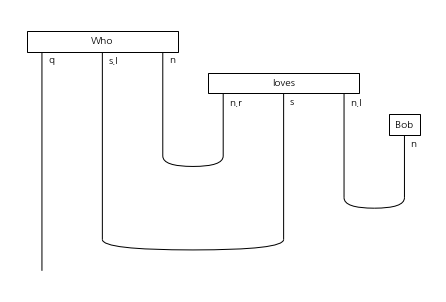

In [64]:
question.draw()

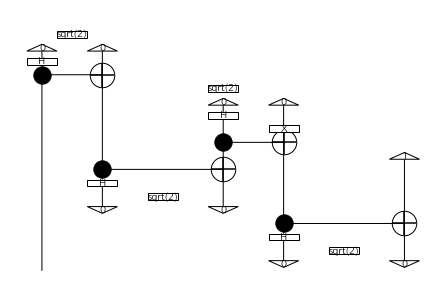

In [65]:
F_.ob[q], F_.ar[Who] = qubit, sqrt(2) @ Ket(0, 0) >> H @ Id(qubit) >> CX
qnlp_question = F_(question)
qnlp_question.draw(fig_size=(6,6))

In [66]:
qnlp_question.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[1.+0.j, 0.+0.j])

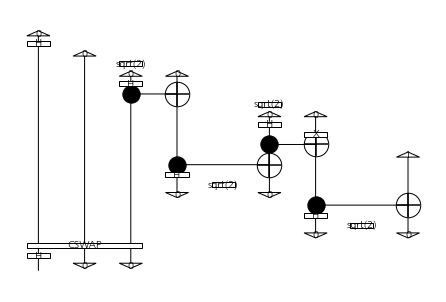

In [69]:
cswap_mat = np.zeros((8, 8), dtype=complex)
cswap_mat[:4, :4] = np.eye(4)
cswap_mat[4:, 4:] = [[1, 0, 0, 0],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1]]
CSWAP = QuantumGate(name="CSWAP", n_qubits=3, array=cswap_mat, _dagger=None)
swap_qnlp_question = ((Ket(0) >> H ) @ F_.ar[Alice] @ qnlp_question) >> CSWAP >> (H @ Bra(0, 0))
swap_qnlp_question.draw()

In [70]:
swap_qnlp_question.eval()

Tensor(dom=Dim(1), cod=Dim(2), array=[1.00000000e+00+0.j, -2.23711432e-17+0.j])

## References

* Coecke, B., Sadrzadeh, M., & Clark, S. (2010) _Mathematical foundations for a compositional distributional model of meaning._ [arXiv:1003.4394](https://arxiv.org/abs/1003.4394)
* Zeng, W., & Coecke, B.  (2016) _Quantum algorithms for compositional natural language processing._ [arXiv:1608.01406](https://arxiv.org/abs/arXiv:1608.01406)
* de Felice, G., Toumi, A., & Coecke, B. (2020) _DisCoPy: Monoidal Categories in Python._ [arXiv:2005.02975](https://arxiv.org/abs/2005.02975)
* Meichanetzidis, K., Toumi, A., de Felice, G., & Coecke, B. (2020) _Grammar-Aware Question-Answering on Quantum Computers._ [arXiv:2012.03756](https://arxiv.org/abs/arXiv:2012.03756)
* Meichanetzidis, K., Gogioso, S., De Felice, G., Chiappori, N., Toumi, A., & Coecke, B. (2020) _Quantum natural language processing on near-term quantum computers._ [arXiv:2005.04147](https://arxiv.org/abs/arXiv:2005.04147)